## Predictive forecasting using python
Domenic Mancuso

Machine Learning using Python Prophet 
Performance Metrics
returns csv file

In [424]:
import numpy as np, pandas as  pd

#xl = pd.read_excel("Downloads/HackathonDataset.xlsx")
#xl.head
df = pd.read_csv("~/Downloads/ERCOT.csv")
df.shape
df.columns


Index(['Date', 'HE', 'P/OP', 'Gen ', 'RT Busbar', 'RT Hub', 'DA Busbar',
       'DA Hub', 'RT Busbar.1', 'RT Hub.1', 'DA Busbar.1', 'DA Hub.1',
       'RT Busbar.2', 'RT Hub.2', 'DA Busbar.2', 'DA Hub.2', 'RT Busbar.3',
       'RT Hub.3', 'DA Busbar.3', 'DA Hub.3', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Peak',
       'Off Peak'],
      dtype='object')

In [425]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')  
df.head


<bound method NDFrame.head of             Date  HE P/OP   Gen  RT Busbar   RT Hub DA Busbar   DA Hub  \
0     2022-01-01   1   OP  36.8     $0.74   $56.43     $5.20   $30.17    
1     2022-01-01   2   OP  17.0    ($3.78)  $29.24     $1.54   $22.08    
2     2022-01-01   3   OP  14.6    ($4.00)  $22.15     $1.83   $19.97    
3     2022-01-01   4   OP  14.6    ($4.00)  $19.59     $2.50   $15.90    
4     2022-01-01   5   OP  14.4    ($4.00)  $13.66    ($1.34)  $10.00    
...          ...  ..  ...    ...       ...      ...       ...      ...   
26299 2024-12-31  20    P  25.0    $24.78   $24.57    $19.92   $28.68    
26300 2024-12-31  21    P  35.5    $25.07   $24.90    $20.31   $28.05    
26301 2024-12-31  22    P  23.4    $22.63   $22.43    $19.53   $23.51    
26302 2024-12-31  23   OP  21.2    $22.23   $22.22    $17.29   $20.09    
26303 2024-12-31  24   OP  18.9    $20.29   $20.29    $18.14   $19.97    

      RT Busbar.1    RT Hub.1  ... DA Busbar.3  DA Hub.3 Unnamed: 20  \
0        

In [426]:
def clean_to_float(x):
    if isinstance(x, str):
        # Remove $, spaces, and handle parentheses for negatives
        cleaned = x.replace('$', '').replace(' ', '')
        if '(' in cleaned and ')' in cleaned:
            cleaned = cleaned.replace('(', '').replace(')', '')
            return -float(cleaned)
        try:
            return float(cleaned)
        except ValueError:
            return 0.0
    else:
        try:
            return float(x)
        except (ValueError, TypeError):
            return 0.0   

In [427]:
def OP_to_onehot(x):
    if isinstance(x, str):
        # Check if both '(' and ')' are present
        try:
            # Replace parentheses and other characters
            cleaned = x.replace('OP', '0').replace('P', '1')
            return cleaned

        except ValueError:
            return None
    else:
          return None

In [428]:
def remove_dash(x):
    if isinstance(x, str):
        if x == '-  ':
            return 0.0
    return x
    

In [429]:
from prophet import Prophet
df['P/OP'] = df['P/OP'].apply(OP_to_onehot)
df['Gen '] = df['Gen '].apply(remove_dash)
#Can change to whichever product to predict. We can also merge multiple product values and predict overall spending.
df = df.rename(columns={'Date': 'ds', 'RT Hub': 'y'})
df['y'] = df['y'].apply(clean_to_float)


# ERCOT_RT_BUSBAR['Gen '][9]
df.head

<bound method NDFrame.head of               ds  HE P/OP   Gen  RT Busbar      y DA Busbar   DA Hub  \
0     2022-01-01   1    0  36.8     $0.74   56.43    $5.20   $30.17    
1     2022-01-01   2    0  17.0    ($3.78)  29.24    $1.54   $22.08    
2     2022-01-01   3    0  14.6    ($4.00)  22.15    $1.83   $19.97    
3     2022-01-01   4    0  14.6    ($4.00)  19.59    $2.50   $15.90    
4     2022-01-01   5    0  14.4    ($4.00)  13.66   ($1.34)  $10.00    
...          ...  ..  ...    ...       ...    ...       ...      ...   
26299 2024-12-31  20    1  25.0    $24.78   24.57   $19.92   $28.68    
26300 2024-12-31  21    1  35.5    $25.07   24.90   $20.31   $28.05    
26301 2024-12-31  22    1  23.4    $22.63   22.43   $19.53   $23.51    
26302 2024-12-31  23    0  21.2    $22.23   22.22   $17.29   $20.09    
26303 2024-12-31  24    0  18.9    $20.29   20.29   $18.14   $19.97    

      RT Busbar.1    RT Hub.1  ... DA Busbar.3  DA Hub.3 Unnamed: 20  \
0         $27.23   $2,076.55   ..

In [430]:

model = Prophet(    changepoint_prior_scale=0.2,  # more flexible trend
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,)
model.add_regressor('HE')
model.add_regressor('P/OP')
model.add_regressor('Gen ')
model.fit(df)
future = model.make_future_dataframe(periods=365, freq='D')
future['HE'] =df['HE']
future['P/OP'] =df['P/OP']
future['Gen '] =df['Gen ']


16:49:25 - cmdstanpy - INFO - Chain [1] start processing
16:49:55 - cmdstanpy - INFO - Chain [1] done processing


In [431]:
forecast = model.predict(future)


# View or save results
forecast = forecast.round(2)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(1000)
forecast.describe


<bound method NDFrame.describe of              ds  trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2022-01-01  10.91      -44.41       72.69        10.91        10.91   
1    2022-01-02  11.20      -47.65       76.32        11.20        11.20   
2    2022-01-03  11.48      -48.76       80.29        11.48        11.48   
3    2022-01-04  11.77      -48.86       78.54        11.77        11.77   
4    2022-01-05  12.05      -42.15       86.78        12.05        12.05   
...         ...    ...         ...         ...          ...          ...   
1456 2025-12-27 -30.36     -755.93      698.30      -389.75       348.96   
1457 2025-12-28 -30.47     -795.82      700.42      -390.61       350.94   
1458 2025-12-29 -30.59     -774.65      694.72      -391.45       353.24   
1459 2025-12-30 -30.71     -757.20      672.05      -392.71       354.73   
1460 2025-12-31 -30.82     -796.22      707.93      -395.44       355.09   

      Gen   Gen _lower  Gen _upper    HE  ...  weekly

In [432]:
csv = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
csv.to_csv('~/Downloads/forecast.csv')
forecast.to_csv('~/Downloads/forecast_detailed.csv')


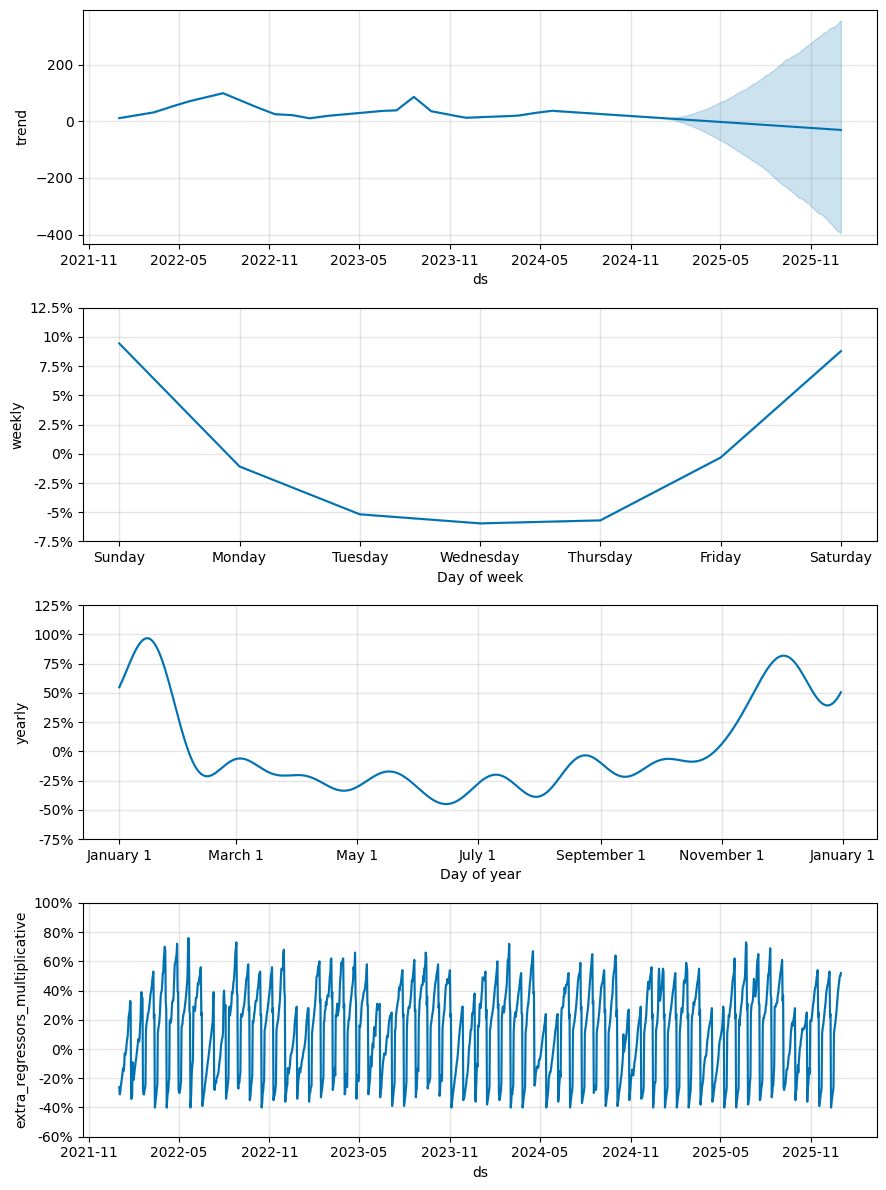

In [433]:

fig = model.plot_components(forecast)

In [434]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
results = forecast[['ds', 'yhat']].merge(df[['ds', 'y']], on='ds')
mae = mean_absolute_error(results['y'], results['yhat'])
rmse = np.sqrt(mean_squared_error(results['y'], results['yhat']))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 21.78, RMSE: 52.75


In [435]:
from prophet.diagnostics import cross_validation

# Example: Use 365 days instead
df_cv = cross_validation(model, horizon='365 days', period='90 days', initial='730 days')
df_perf = performance_metrics(df_cv)
print(df_perf)   

  0%|          | 0/1 [00:00<?, ?it/s]16:49:57 - cmdstanpy - INFO - Chain [1] start processing
16:50:09 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:15<00:00, 15.60s/it]


     horizon           mse        rmse         mae      mdape     smape  \
0    37 days   3203.203596   56.596851   36.846376   1.365134  1.854966   
1    38 days   3222.750062   56.769270   37.238156   1.392518  1.878600   
2    39 days   3259.020611   57.087832   37.852326   1.436468  1.902128   
3    40 days   3283.104116   57.298378   38.343502   1.456987  1.921228   
4    41 days   3285.170464   57.316407   38.472494   1.493757  1.933773   
..       ...           ...         ...         ...        ...       ...   
324 361 days  88054.630170  296.740004  291.129852  12.802123  1.997994   
325 362 days  89503.047564  299.170599  293.805789  12.955146  1.997994   
326 363 days  90873.651266  301.452569  296.346759  13.029193  1.997994   
327 364 days  92612.898134  304.323673  299.309753  13.058976  1.996627   
328 365 days  94326.754144  307.126609  302.168100  13.245459  1.996638   

     coverage  
0    0.912100  
1    0.912100  
2    0.912100  
3    0.912100  
4    0.912671  
.. 